In [29]:
import seaborn as sns
from software.data_collector import get_data_for_period
from software.data_processor import process_data
from software.backtester import run_back_test
from software.plotter import plot_bollinger_bands, plot_ema_and_sma, plot_rsi, plot_atr, plot_signals
from software.strategy import Strategy

%matplotlib inline
sns.set_style('darkgrid')

# transactions_df = run_back_test(
#     ticker=ticker,
#     initial_cash=3000,
#     transaction_cost=0.001,
#     leverage=1,
#     slippage_pct=0.0005,
#     risk_per_trade=0.05,
# )

ticker = "^FCHI"
start_date = "2024-10-24 09:30:00"
end_date = "2024-10-24 12:00:00"
interval = "1m"

sma_period=5,
ema_period=20,
rsi_period=7,
bbands_period=20,
atr_period=14,

initial_cash = 1000

data = get_data_for_period(ticker=ticker, start_date=start_date, end_date=end_date, interval=interval)
# period_data = f"{start_date}_{end_date}"
processed_data = process_data(
    data,
    sma_period=sma_period,
    ema_period=ema_period,
    rsi_period=rsi_period,
    bbands_period=bbands_period,
    atr_period=atr_period,
)

strategy = Strategy(
    ema_sma_threshold=0,
    rsi_long_threshold=40,
    rsi_short_threshold=60,
    bb_threshold=0,
)


2024-10-26 16:07:22,378 - ERROR - Error in adding technical indicators: '>' not supported between instances of 'tuple' and 'int'
2024-10-26 16:07:22,379 - ERROR - Error in processing data: Error in adding technical indicators: '>' not supported between instances of 'tuple' and 'int'


RuntimeError: Error in processing data: Error in adding technical indicators: '>' not supported between instances of 'tuple' and 'int'

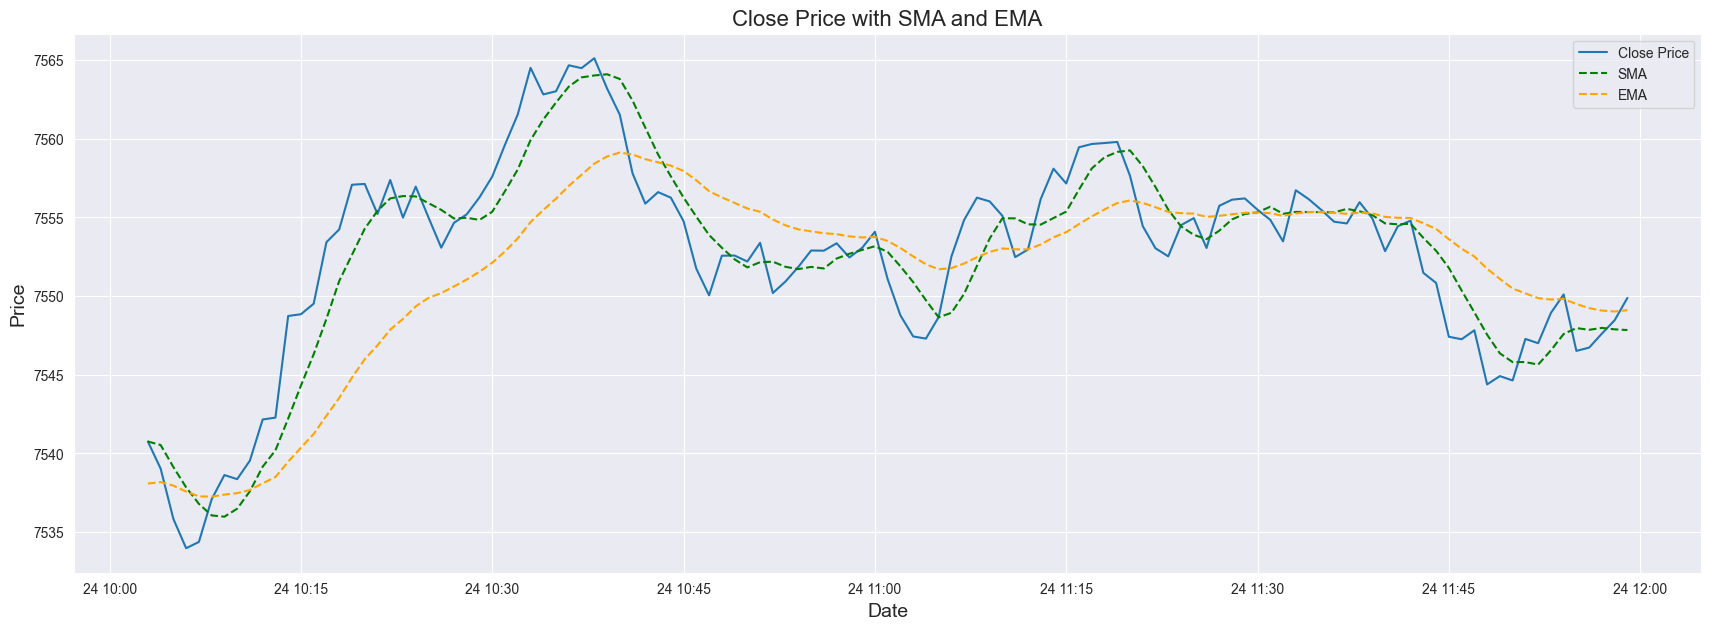

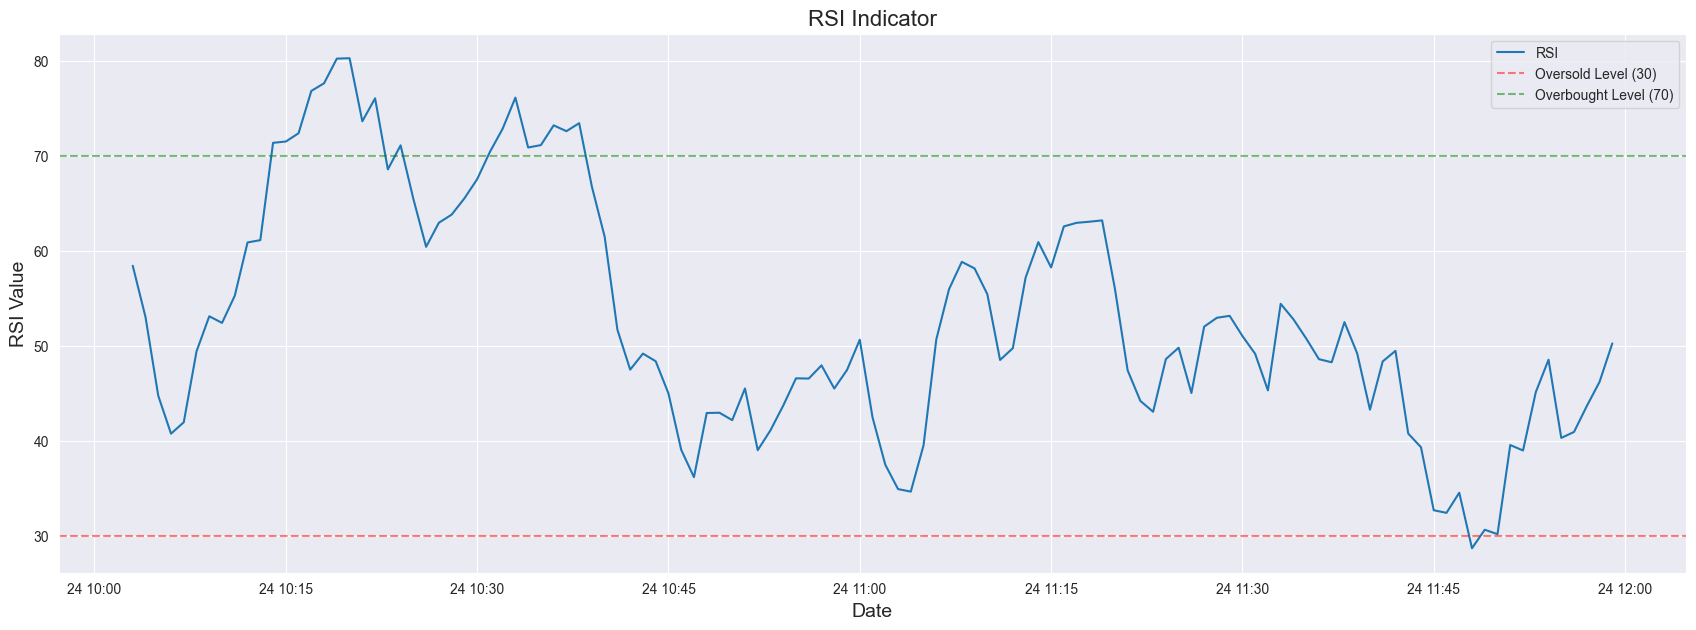

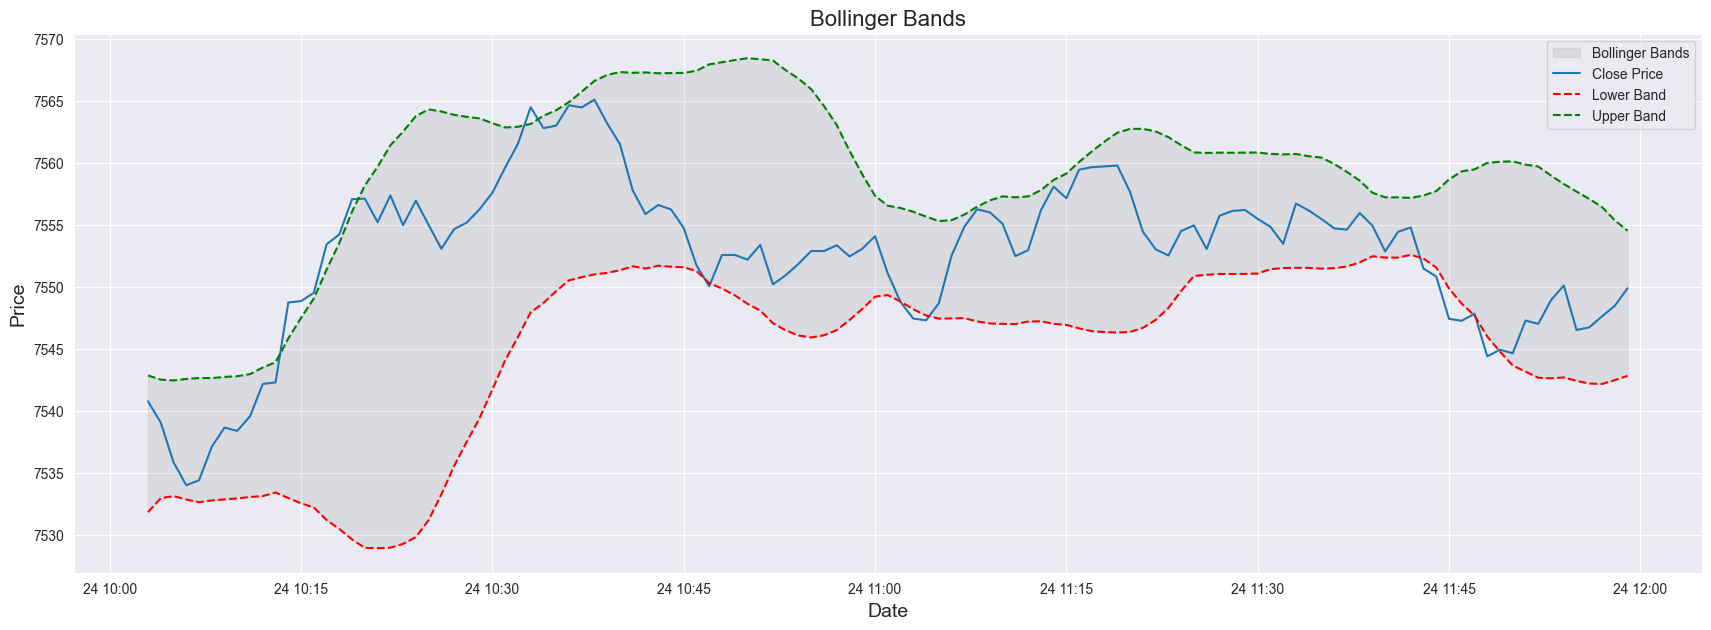

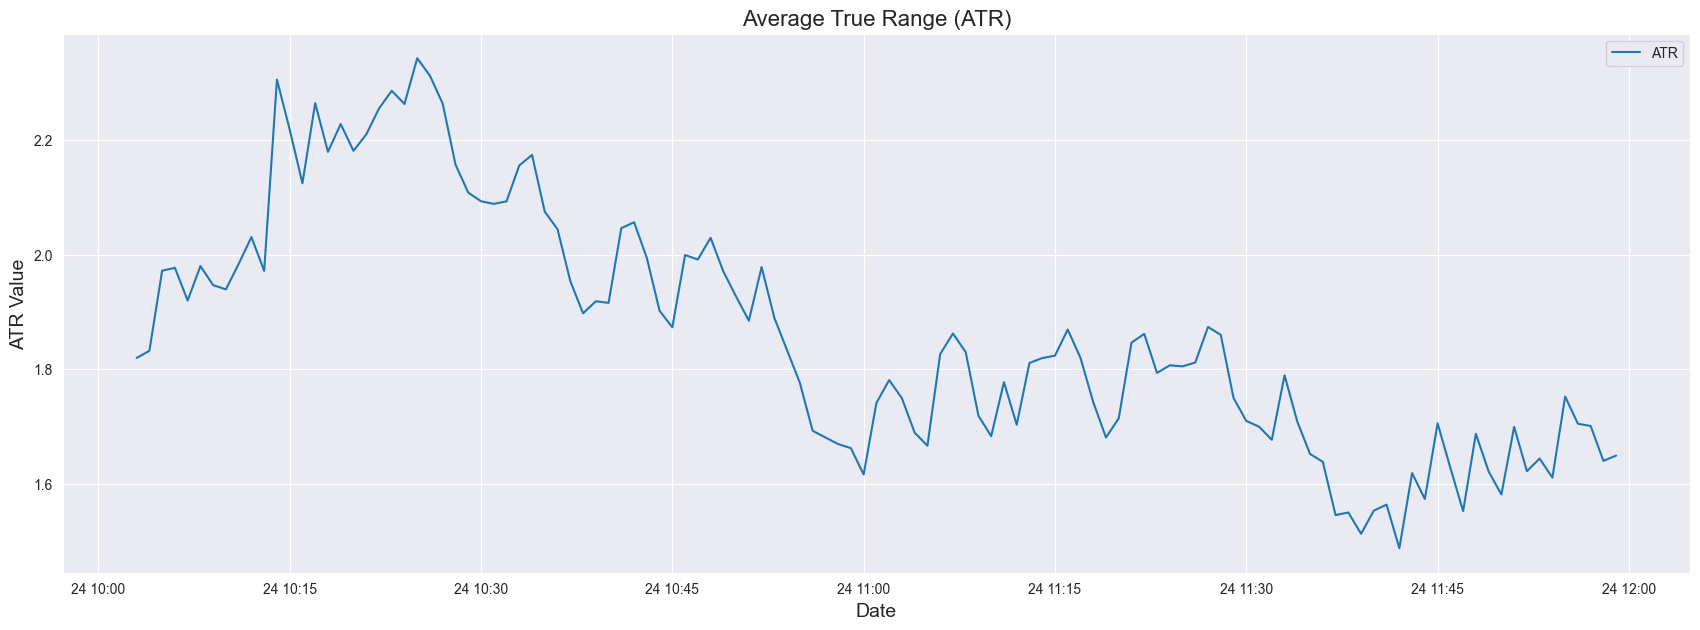

In [13]:
plot_ema_and_sma(processed_data)
plot_rsi(processed_data)
plot_bollinger_bands(processed_data)
plot_atr(processed_data)

In [21]:

data_with_signals = strategy.generate_buy_signals(processed_data)

Signals : [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


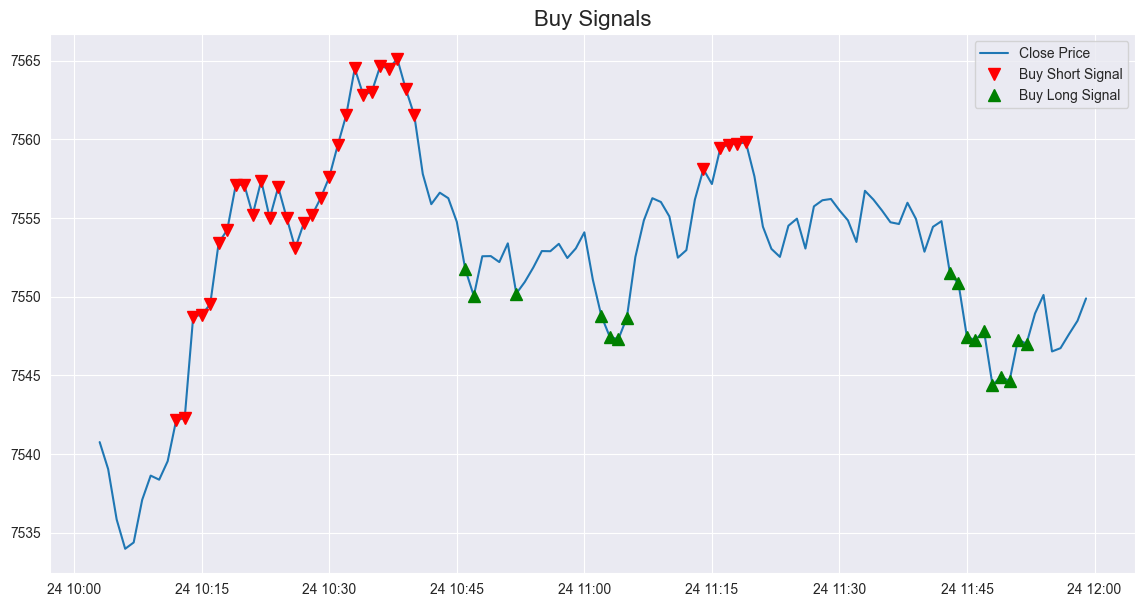

In [24]:
print("Signals :", data_with_signals["Signal"].tolist())
plot_signals(processed_data)

In [ ]:
transactions, equity_curve, dates = execute_trades(
    data=data_with_signals,
    initial_cash=initial_cash,
    transaction_cost=transaction_cost,
    leverage=leverage,
    slippage_pct=slippage_pct,
    risk_per_trade=risk_per_trade,
)

In [11]:



performance_metrics = evaluate_performance(
    transactions, equity_curve, initial_cash
)

plot_results(equity_curve, dates)

final_portfolio_value = equity_curve[-1]
total_profit = final_portfolio_value - initial_cash
print(f"Total Profit: ${total_profit:.2f}")

NameError: name 'sma_period' is not defined